# Predicting clicks on ads

Borrowing from [here](https://turi.com/learn/gallery/notebooks/click_through_rate_prediction_intro.html):


> Many ads are actually sold on a "pay-per-click" (PPC) basis, meaning the company only pays for ad clicks, not ad views. Thus your optimal approach (as a search engine) is actually to choose an ad based on "expected value", meaning the price of a click times the likelihood that the ad will be clicked [...] In order for you to maximize expected value, you therefore need to accurately predict the likelihood that a given ad will be clicked, also known as "click-through rate" (CTR).

In this project I will predict the likelihood that a given online ad will be clicked.

## Dataset 

- The two files `train_click.csv` and `test_click.csv` contain ad impression attributes from a campaign.
- Each row in `train.csv` includes a `click` column.

## Import the relevant libraries and the files

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute   # used for feature imputation algorithms
pd.set_option('display.max_columns', None) # display all columns
pd.set_option('display.max_rows', None)  # displays all rows
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # so we can see the value of multiple statements at once.

train = pd.read_csv('train_click.csv',index_col=0)
test = pd.read_csv('test_click.csv',index_col=0)
train.head()
test.head()

,location,carrier,website,publisher,device,day,hour,dimension,click
0,0,3,667,221,1,2,14,1,0
1,0,0,667,221,1,6,13,1,0
2,0,0,1300,221,2,4,11,1,0
3,0,0,1145,221,4,2,11,1,0
4,0,0,1300,221,1,6,11,1,0


,location,carrier,website,publisher,device,day,hour,dimension
0,1,0,1172,186,2,5,0,3
1,2,2,272,378,2,5,0,1
2,0,0,721,402,1,5,0,0
3,0,0,830,156,3,2,0,3
4,0,0,272,378,1,5,0,1


## Data Dictionary

- location – ad placement in the website
- carrier – mobile carrier 
- device – type of device e.g. phone, tablet or computer 
- day – weekday user saw the ad
- hour – hour user saw the ad
- dimension – size of ad

### Checking for matches and differences between train and test sets 

I will check if there are feature categories in the test set that are absent from the training set. This can lead to prediction problems (e.g. how to predicts clicks for a given website  if the trained model never "saw" that domain?)

In [15]:
train_clean = train.copy()
test_clean = test.copy()
for col in test.columns.tolist():
    print('matches for {}:'.format(col),len(set(train_clean[col].unique().tolist()) 
                                                  & set(test_clean[col].unique().tolist())))

matches for location: 3
matches for carrier: 5
matches for website: 1721
matches for publisher: 592
matches for device: 6
matches for day: 7
matches for hour: 21
matches for dimension: 5


Is this a large part of the test set? **No.**

In [16]:
for col in test.columns.tolist():
    print('% matches for {}:'.format(col),
          round((100/train_clean.shape[0])*len(set(train_clean[col].unique().tolist()) 
                                                  & set(test_clean[col].unique().tolist())),5))

% matches for location: 0.00188
% matches for carrier: 0.00313
% matches for website: 1.07565
% matches for publisher: 0.37001
% matches for device: 0.00375
% matches for day: 0.00438
% matches for hour: 0.01313
% matches for dimension: 0.00313


In [17]:
for col in test.columns.tolist():
    print('unique {}s in the test set:'.format(col),len(train_clean[col].unique().tolist()))

unique locations in the test set: 3
unique carriers in the test set: 5
unique websites in the test set: 2699
unique publishers in the test set: 823
unique devices in the test set: 6
unique days in the test set: 7
unique hours in the test set: 21
unique dimensions in the test set: 5


### Imbalance
The `click` column is **heavily** unbalanced. I will correct for this later.

In [19]:
import aux_func_v2 as af

af.s_to_df(train['click'].value_counts())

,column
col_name,
0,159270
1,726


### Checking the variance of each feature

Let's quickly study the variance of the features to have an estimate of their impact on clicks. But let us first consider the cardinalities.

#### Train set cardinalities

In [20]:
cardin_train = [train[col].nunique() for col in train.columns.tolist()]
cols = [col for col in train.columns.tolist()]
d = {k:v for (k, v) in zip(cols,cardin_train)}
cardinal_train = pd.DataFrame(list(d.items()), columns=['column', 'cardinality'])
cardinal_train.sort_values('cardinality',ascending=False)

,column,cardinality
2,website,2699
3,publisher,823
6,hour,21
5,day,7
4,device,6
1,carrier,5
7,dimension,5
0,location,3
8,click,2


#### Test set cardinalities

In [21]:
cardin_test = [test[col].nunique() for col in test.columns.tolist()]
cols = [col for col in test.columns.tolist()]
d = {k:v for (k, v) in zip(cols,cardin_test)}
cardinal_test = pd.DataFrame(list(d.items()), columns=['column', 'cardinality'])
cardinal_test.sort_values('cardinality',ascending=False)

,column,cardinality
2,website,1722
3,publisher,592
6,hour,21
5,day,7
4,device,6
1,carrier,5
7,dimension,5
0,location,3


#### High and low cardinality in the training data

We can set *arbitrary* thresholds to determine the level of cardinality in the feature categories:

In [23]:
target = 'click'
cardinal_train_threshold = 33  # our choice
low_cardinal_train = cardinal_train[cardinal_train['cardinality'] 
                                    <= cardinal_train_threshold]['column'].tolist()
low_cardinal_train.remove(target)
high_cardinal_train = cardinal_train[cardinal_train['cardinality'] 
                                     > cardinal_train_threshold]['column'].tolist()
print('Features with low cardinal_train:\n',low_cardinal_train)
print('')
print('Features with high cardinal_train:\n',high_cardinal_train)

Features with low cardinal_train:
 ['location', 'carrier', 'device', 'day', 'hour', 'dimension']

Features with high cardinal_train:
 ['website', 'publisher']


#### High and low cardinality in the test data

In [24]:
cardinal_test_threshold = 25  # chosen for low_cardinal_set to agree with low_cardinal_train
low_cardinal_test = cardinal_test[cardinal_test['cardinality'] 
                                  <= cardinal_test_threshold]['column'].tolist()
high_cardinal_test = cardinal_test[cardinal_test['cardinality']
                                   > cardinal_test_threshold]['column'].tolist()
print('Features with low cardinal_test:\n',low_cardinal_test)
print('')
print('Features with high cardinal_test:\n',high_cardinal_test)

Features with low cardinal_test:
 ['location', 'carrier', 'device', 'day', 'hour', 'dimension']

Features with high cardinal_test:
 ['website', 'publisher']


#### Now let's look at the features' variances. 

From the bar plot below we see that `device_type` has non-negligible variance

In [25]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

Text(0.5,0,'location')

Text(0,0.5,'Clicks')

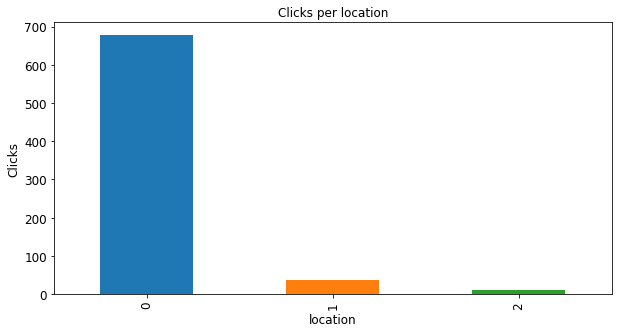

Text(0.5,0,'carrier')

Text(0,0.5,'Clicks')

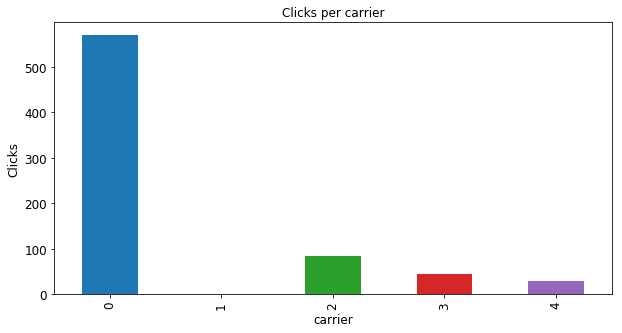

Text(0.5,0,'device')

Text(0,0.5,'Clicks')

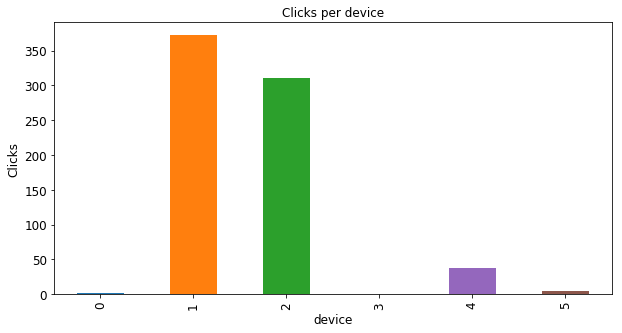

Text(0.5,0,'day')

Text(0,0.5,'Clicks')

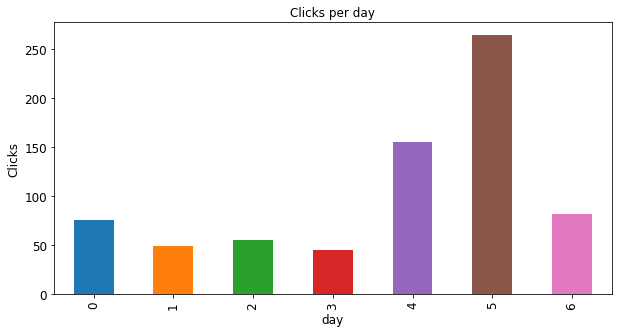

Text(0.5,0,'hour')

Text(0,0.5,'Clicks')

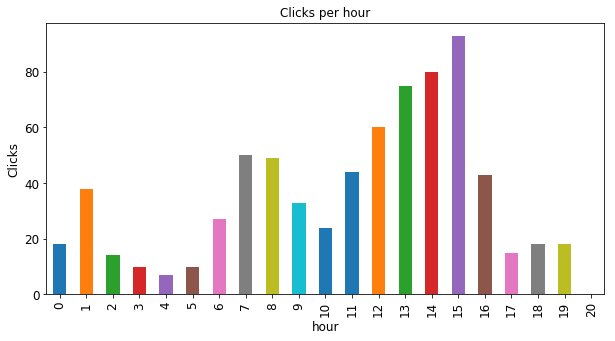

Text(0.5,0,'dimension')

Text(0,0.5,'Clicks')

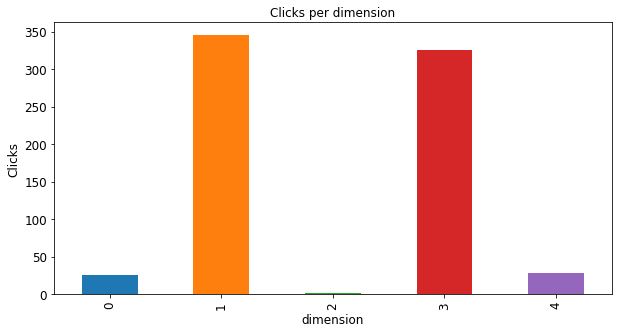

In [26]:
for col in low_cardinal_train:
    ax = train[target].groupby(train[col]).sum().plot(kind='bar', 
                                                                title ="Clicks per " + col, 
                                                                figsize=(10, 5), fontsize=12);
    ax.set_xlabel(col, fontsize=12);
    ax.set_ylabel("Clicks", fontsize=12);
    plt.show();

### Dropping some features

Notice that some of the features are massively dominated by **just one level**. We will drop those. We have to
do that for both train and test sets:

In [27]:
cols_to_drop = ['location']
train_new = train.drop(cols_to_drop,axis=1)
test_new = test.drop(cols_to_drop,axis=1)

In [28]:
train_new.head()
test_new.head()

,carrier,website,publisher,device,day,hour,dimension,click
0,3,667,221,1,2,14,1,0
1,0,667,221,1,6,13,1,0
2,0,1300,221,2,4,11,1,0
3,0,1145,221,4,2,11,1,0
4,0,1300,221,1,6,11,1,0


,carrier,website,publisher,device,day,hour,dimension
0,0,1172,186,2,5,0,3
1,2,272,378,2,5,0,1
2,0,721,402,1,5,0,0
3,0,830,156,3,2,0,3
4,0,272,378,1,5,0,1


In [29]:
train.shape
test.shape
train_new.shape
test_new.shape

(159996, 9)

(53333, 8)

(159996, 8)

(53333, 7)

<a id = 'dtypes'></a> 
### Data types

In [30]:
train_new.dtypes
test_new.dtypes

carrier      int64
website      int64
publisher    int64
device       int64
day          int64
hour         int64
dimension    int64
click        int64
dtype: object

carrier      int64
website      int64
publisher    int64
device       int64
day          int64
hour         int64
dimension    int64
dtype: object

#### Converting some of the integer columns into strings:

In [ ]:
cols_to_convert = test_new.columns.tolist()
for col in cols_to_convert:
    train_new[col] = train_new[col].astype(str)
    test_new[col] = test_new[col].astype(str)

In [32]:
train_new.dtypes
test_new.dtypes

carrier      object
website      object
publisher    object
device       object
day          object
hour         object
dimension    object
click         int64
dtype: object

carrier      object
website      object
publisher    object
device       object
day          object
hour         object
dimension    object
dtype: object


## Handling missing values

The only column with missing values is the `domain` column. There are several ways to fill missing values including:
- Dropping the corresponding rows
- Filling `NaNs` using most the frequent value.
- Using Multiple Imputation by Chained Equations of MICE is a more sophisticated option

In our case, the are only a relatively small percentage of `NaNs` in just one column, namely, $\approx$ 13$\%$ of domain values are missing. I opted for values imputation to avoid dropping rows. Future analysis using MICE should improve final results.

In [33]:
train_new['website'] = train_new[['website']].apply(lambda x:x.fillna(x.value_counts().index[0]))  
train_new.isnull().any()

carrier      False
website      False
publisher    False
device       False
day          False
hour         False
dimension    False
click        False
dtype: bool

In [34]:
test_new['website'] = test_new[['website']].apply(lambda x:x.fillna(x.value_counts().index[0]))  
test_new.isnull().any()

carrier      False
website      False
publisher    False
device       False
day          False
hour         False
dimension    False
dtype: bool

<a id = 'dummies'></a> 
### Dummies

We can transform the categories with low cardinality into dummies using hot encoding:

In [35]:
cols_to_keep = ['carrier', 'device', 'day', 'hour', 'dimension']
low_cardin_train = train_new[cols_to_keep]
low_cardin_test = test_new[cols_to_keep]
dummies_train = pd.concat([pd.get_dummies(low_cardin_train[col], drop_first = True, prefix= col) 
                     for col in cols_to_keep], axis=1)
dummies_test = pd.concat([pd.get_dummies(low_cardin_test[col], drop_first = True, prefix= col) 
                     for col in cols_to_keep], axis=1)
dummies_train.head()
dummies_test.head()

,carrier_1,carrier_2,carrier_3,carrier_4,device_1,device_2,device_3,device_4,device_5,day_1,day_2,day_3,day_4,day_5,day_6,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_2,hour_20,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,dimension_1,dimension_2,dimension_3,dimension_4
0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


,carrier_1,carrier_2,carrier_3,carrier_4,device_1,device_2,device_3,device_4,device_5,day_1,day_2,day_3,day_4,day_5,day_6,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_2,hour_20,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,dimension_1,dimension_2,dimension_3,dimension_4
0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
train_new.to_csv('train_new.csv')
test_new.to_csv('test_new.csv')

#### Concatenating with the rest of the `DataFrame`:

In [39]:
train_new = pd.concat([train_new[high_cardinal_train + ['click']], dummies_train], axis = 1)
test_new = pd.concat([test_new[high_cardinal_test], dummies_test], axis = 1)

In [40]:
train_new.head()
test_new.head()
train_new.shape
test_new.shape

,website,publisher,click,carrier_1,carrier_2,carrier_3,carrier_4,device_1,device_2,device_3,device_4,device_5,day_1,day_2,day_3,day_4,day_5,day_6,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_2,hour_20,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,dimension_1,dimension_2,dimension_3,dimension_4
0,667,221,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,667,221,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1300,221,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1145,221,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1300,221,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


,website,publisher,carrier_1,carrier_2,carrier_3,carrier_4,device_1,device_2,device_3,device_4,device_5,day_1,day_2,day_3,day_4,day_5,day_6,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_2,hour_20,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,dimension_1,dimension_2,dimension_3,dimension_4
0,1172,186,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,272,378,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,721,402,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,830,156,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,272,378,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


(159996, 42)

(53333, 41)

In [41]:
# exporting new csv
train_new.to_csv('train_new.csv')
test_new.to_csv('test_new.csv')

Now, to treat the columns with high cardinality, we will break them up into percentiles based on the number of impressions (number of rows). 

#### Building up dictionaries for creation of dummy variables

In [42]:
train_new['count'] = 1   # auxiliar column
test_new['count'] = 1

In [43]:
train_new.head()
test_new.head()

,website,publisher,click,carrier_1,carrier_2,carrier_3,carrier_4,device_1,device_2,device_3,device_4,device_5,day_1,day_2,day_3,day_4,day_5,day_6,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_2,hour_20,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,dimension_1,dimension_2,dimension_3,dimension_4,count
0,667,221,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,667,221,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,1300,221,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,1145,221,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,1300,221,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


,website,publisher,carrier_1,carrier_2,carrier_3,carrier_4,device_1,device_2,device_3,device_4,device_5,day_1,day_2,day_3,day_4,day_5,day_6,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_2,hour_20,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,dimension_1,dimension_2,dimension_3,dimension_4,count
0,1172,186,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,272,378,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,721,402,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,830,156,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,272,378,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [44]:
train_new.shape
test_new.shape

(159996, 43)

(53333, 42)

#### In the next cell, I use `pd.cut` to rename column entries using percentiles

In [50]:
train_new.head()

,website,publisher,click,carrier_1,carrier_2,carrier_3,carrier_4,device_1,device_2,device_3,device_4,device_5,day_1,day_2,day_3,day_4,day_5,day_6,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_2,hour_20,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,dimension_1,dimension_2,dimension_3,dimension_4,count
0,667,221,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,667,221,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,1300,221,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,1145,221,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,1300,221,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [54]:
def series_to_dataframe(s,name,index_list):
    lst = [s.iloc[i] for i in range(s.shape[0])]
    new_df = pd.DataFrame({name: lst})  # transforms list into dataframe
    new_df.index = index_list
    return new_df

In [55]:
def ranges(df1,col):
        df = series_to_dataframe(df1['count'].groupby(df1[col]).sum(),
                             'sum of ads',
                             df1['count'].groupby(df1[col]).sum().index.tolist()).sort_values('sum of ads',ascending=False)
        #print('How the pd.cut looks like:\n')
        #print(pd.get_dummies(pd.cut(df['sum of ads'], 3)).head(3))
        df = pd.concat([df,pd.get_dummies(pd.cut(df['sum of ads'], 3), drop_first = True)],axis=1)
        df.columns = ['sum of ads',col + '_1',col + '_2']
        return df

In [59]:
website_train = ranges(train_new,'website')
publisher_train = ranges(train_new,'publisher')

In [60]:
website_train.head()
publisher_train.head()

,sum of ads,website_1,website_2
1300,37601,0,1
0,20692,1,0
667,14134,1,0
1145,10212,0,0
1590,6123,0,0


,sum of ads,publisher_1,publisher_2
221,78391,0,1
726,22326,0,0
292,7973,0,0
747,6587,0,0
133,5652,0,0


In [61]:
website_test = ranges(test_new,'website')
publisher_test = ranges(test_new,'publisher')

In [62]:
website_test.head()
publisher_test.head()

,sum of ads,website_1,website_2
830,12677,0,1
-1,6861,1,0
432,4695,1,0
740,3419,0,0
1022,2039,0,0


,sum of ads,publisher_1,publisher_2
156,26175,0,1
528,7538,0,0
212,2569,0,0
543,2221,0,0
99,1796,0,0


In [63]:
website_train.reset_index(level=0, inplace=True)
publisher_train.reset_index(level=0, inplace=True)
website_test.reset_index(level=0, inplace=True)
publisher_test.reset_index(level=0, inplace=True)

In [65]:
website_train.head()
publisher_train.head()

,index,sum of ads,website_1,website_2
0,1300,37601,0,1
1,0,20692,1,0
2,667,14134,1,0
3,1145,10212,0,0
4,1590,6123,0,0


,index,sum of ads,publisher_1,publisher_2
0,221,78391,0,1
1,726,22326,0,0
2,292,7973,0,0
3,747,6587,0,0
4,133,5652,0,0


In [66]:
website_test.head()
publisher_test.head()

,index,sum of ads,website_1,website_2
0,830,12677,0,1
1,-1,6861,1,0
2,432,4695,1,0
3,740,3419,0,0
4,1022,2039,0,0


,index,sum of ads,publisher_1,publisher_2
0,156,26175,0,1
1,528,7538,0,0
2,212,2569,0,0
3,543,2221,0,0
4,99,1796,0,0


In [67]:
website_train.columns = ['website', 'sum of impressions', 'website_1', 'website_2']
publisher_train.columns = ['publisher', 'sum of impressions', 'publisher_1', 'publisher_2']

In [68]:
website_train.head()
publisher_train.head()

,website,sum of impressions,website_1,website_2
0,1300,37601,0,1
1,0,20692,1,0
2,667,14134,1,0
3,1145,10212,0,0
4,1590,6123,0,0


,publisher,sum of impressions,publisher_1,publisher_2
0,221,78391,0,1
1,726,22326,0,0
2,292,7973,0,0
3,747,6587,0,0
4,133,5652,0,0


In [69]:
website_train.shape
publisher_train.shape

(2699, 4)

(823, 4)

In [70]:
website_test.columns = ['website', 'sum of impressions', 'website_1', 'website_2']
publisher_test.columns = ['publisher', 'sum of impressions', 'publisher_1', 'publisher_2']
website_test.head()
publisher_test.head()

,website,sum of impressions,website_1,website_2
0,830,12677,0,1
1,-1,6861,1,0
2,432,4695,1,0
3,740,3419,0,0
4,1022,2039,0,0


,publisher,sum of impressions,publisher_1,publisher_2
0,156,26175,0,1
1,528,7538,0,0
2,212,2569,0,0
3,543,2221,0,0
4,99,1796,0,0


In [71]:
train_new = train_new.merge(website_train, how='left')
train_new = train_new.drop('website',axis=1).drop('sum of impressions',axis=1)
train_new.head()
train_new.shape

,publisher,click,carrier_1,carrier_2,carrier_3,carrier_4,device_1,device_2,device_3,device_4,device_5,day_1,day_2,day_3,day_4,day_5,day_6,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_2,hour_20,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,dimension_1,dimension_2,dimension_3,dimension_4,count,website_1,website_2
0,221,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0
1,221,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0
2,221,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
3,221,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,221,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1


(159996, 44)

In [72]:
train_new = train_new.merge(publisher_train, how='left')
train_new = train_new.drop('publisher',axis=1).drop('sum of impressions',axis=1)
train_new.head()
train_new.shape

,click,carrier_1,carrier_2,carrier_3,carrier_4,device_1,device_2,device_3,device_4,device_5,day_1,day_2,day_3,day_4,day_5,day_6,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_2,hour_20,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,dimension_1,dimension_2,dimension_3,dimension_4,count,website_1,website_2,publisher_1,publisher_2
0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1
2,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1
3,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1


(159996, 45)

In [105]:
train_new.shape

(159996, 48)

In [107]:
train_new.to_csv('train_1.csv')

In [73]:
test_new = test_new.merge(website_test, how='left')
test_new = test_new.drop('website',axis=1).drop('sum of impressions',axis=1)
test_new.head()
test_new.shape

,publisher,carrier_1,carrier_2,carrier_3,carrier_4,device_1,device_2,device_3,device_4,device_5,day_1,day_2,day_3,day_4,day_5,day_6,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_2,hour_20,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,dimension_1,dimension_2,dimension_3,dimension_4,count,website_1,website_2
0,186,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,378,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,402,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,156,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
4,378,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


(53333, 43)

In [74]:
test_new = test_new.merge(publisher_test, how='left')
test_new = test_new.drop('publisher',axis=1).drop('sum of impressions',axis=1)
test_new.head()
test_new.shape

,carrier_1,carrier_2,carrier_3,carrier_4,device_1,device_2,device_3,device_4,device_5,day_1,day_2,day_3,day_4,day_5,day_6,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_2,hour_20,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,dimension_1,dimension_2,dimension_3,dimension_4,count,website_1,website_2,publisher_1,publisher_2
0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1
4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


(53333, 44)

In [75]:
train_new.to_csv('train_2.csv')
test_new.to_csv('test_2.csv')


## Imbalanced classes

<a id = 'umb'></a>
#### Imbalanced classes in general

- We can account for unbalanced classes using:
  - Undersampling: randomly sample the majority class, artificially balancing the classes when fitting the model
  - Oversampling: boostrap (sample with replacement) the minority class to balance the classes when fitting the model. We can oversample using the SMOTE algorithm (Synthetic Minority Oversampling Technique) 
- Note that it is crucial that we **evaluate our model on the real data!!**

In [77]:
zeros = train_new[train_new['click'] == 0]
ones = train_new[train_new['click'] == 1]
counts = train_new['click'].value_counts()
proportion = counts[1]/counts[0]
train_new = ones.append(zeros.sample(frac=proportion))
#train_new['response'].value_counts()

In [78]:
train_new.head()

,click,carrier_1,carrier_2,carrier_3,carrier_4,device_1,device_2,device_3,device_4,device_5,day_1,day_2,day_3,day_4,day_5,day_6,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_2,hour_20,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,dimension_1,dimension_2,dimension_3,dimension_4,count,website_1,website_2,publisher_1,publisher_2
159270,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
159271,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
159272,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
159273,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0
159274,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [119]:
#train_new.shape
#train_new.isnull().any()

In [79]:
train_new.to_csv('train_undersampling.csv')

# Models

In [81]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer, TfidfTransformer
import seaborn as sns
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [ ]:
X_test = test_new

In [82]:
# Defining ranges for the hyperparameters to be scanned by the grid search
n_estimators = list(range(20,120,10))
max_depth = list(range(2, 22, 2)) + [None]

def random_forest_score(df,target_col,test_size,n_estimators,max_depth):
    
    X_train = df.drop(target_col, axis=1)   # predictors
    y_train = df[target_col]                # target
    X_test = test_new
    
    rf_params = {
             'n_estimators':n_estimators,
             'max_depth':max_depth}   # parameters for grid search
    rf_gs = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, verbose=1, n_jobs=-1)
    rf_gs.fit(X_train,y_train) # training the random forest with all possible parameters
    print('The best parameters on the training data are:\n',rf_gs.best_params_) # printing the best parameters
    max_depth_best = rf_gs.best_params_['max_depth']      # getting the best max_depth
    n_estimators_best = rf_gs.best_params_['n_estimators']  # getting the best n_estimators
    print("best max_depth:",max_depth_best)
    print("best n_estimators:",n_estimators_best)
    best_rf_gs = RandomForestClassifier(max_depth=max_depth_best,n_estimators=n_estimators_best) # instantiate the best model
    best_rf_gs.fit(X_train,y_train)  # fitting the best model
    preds = best_rf_gs.predict(X_test)
    feature_importances = pd.Series(best_rf_gs.feature_importances_, index=X_train.columns).sort_values().tail(5)
    print(feature_importances.plot(kind="barh", figsize=(6,6)))
    return 

Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:   26.8s finished


The best parameters on the training data are:
 {'max_depth': 14, 'n_estimators': 80}
best max_depth: 14
best n_estimators: 80
AxesSubplot(0.125,0.125;0.775x0.755)


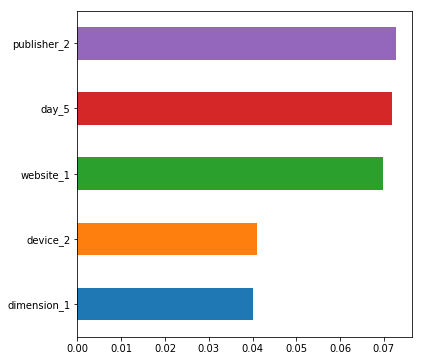

In [83]:
random_forest_score(train_new,'click',0.3,n_estimators,max_depth)

In [85]:
X = train_new.drop('click', axis=1)   # predictors
y = train_new['click']  

In [86]:
def cv_score(X,y,cv,n_estimators,max_depth):
    rf = RandomForestClassifier(n_estimators=n_estimators_best,
                                max_depth=max_depth_best)
    s = cross_val_score(rf, X, y, cv=cv, n_jobs=-1)
    return("{} Score is :{:0.3} ± {:0.3}".format("Random Forest", s.mean().round(3), s.std().round(3)))

In [87]:
dict_best = {'max_depth': 14, 'n_estimators': 80}
n_estimators_best = dict_best['n_estimators']
max_depth_best = dict_best['max_depth']
cv_score(X,y,5,n_estimators_best,max_depth_best)

'Random Forest Score is :0.723 ± 0.007'

In [91]:
n_estimators = list(range(20,120,10))
max_depth = list(range(2, 16, 2)) + [None]

def random_forest_score_probas(df,target_col,test_size,n_estimators,max_depth):
    
    X_train = df.drop(target_col, axis=1)   # predictors
    y_train = df[target_col]                # target
    X_test = test_new
    
    rf_params = {
             'n_estimators':n_estimators,
             'max_depth':max_depth}   # parameters for grid search
    rf_gs = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, n_jobs=-1)
    rf_gs.fit(X_train,y_train) # training the random forest with all possible parameters
    max_depth_best = rf_gs.best_params_['max_depth']      # getting the best max_depth
    n_estimators_best = rf_gs.best_params_['n_estimators']  # getting the best n_estimators
    best_rf_gs = RandomForestClassifier(max_depth=max_depth_best,n_estimators=n_estimators_best) # instantiate the best model
    best_rf_gs.fit(X_train,y_train)  # fitting the best model
    preds = best_rf_gs.predict(X_test)
    prob_list = [prob[0] for prob in best_rf_gs.predict_proba(X_test).tolist()]
    df_prob = pd.DataFrame(np.array(prob_list).reshape(53333,1))
    df_prob.columns = ['probabilities']
    df_prob.to_csv('probs.csv')
    return df_prob

In [92]:
random_forest_score_probas(train_new,'click',0.3,n_estimators,max_depth).head()

,probabilities
0,0.401281
1,0.303518
2,0.417348
3,0.711746
4,0.376414


In [93]:
def random_forest_score_preds(df,target_col,test_size,n_estimators,max_depth):
    
    X_train = df.drop(target_col, axis=1)   # predictors
    y_train = df[target_col]                # target
    X_test = test_new
    
    rf_params = {
             'n_estimators':n_estimators,
             'max_depth':max_depth}   # parameters for grid search
    rf_gs = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, verbose=1, n_jobs=-1)
    rf_gs.fit(X_train,y_train) # training the random forest with all possible parameters
    max_depth_best = rf_gs.best_params_['max_depth']      # getting the best max_depth
    n_estimators_best = rf_gs.best_params_['n_estimators']  # getting the best n_estimators
    best_rf_gs = RandomForestClassifier(max_depth=max_depth_best,n_estimators=n_estimators_best) # instantiate the best model
    best_rf_gs.fit(X_train,y_train)  # fitting the best model
    preds = best_rf_gs.predict(X_test)
    df_pred = pd.DataFrame(np.array(preds).reshape(53333,1))
    df_pred.columns = ['predictions']
    df_pred.to_csv('preds.csv')
    return df_pred

In [94]:
random_forest_score_preds(train_new,'click',0.3,n_estimators,max_depth).head()

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   21.7s finished


,predictions
0,1
1,1
2,1
3,0
4,1
